Question:
You are tasked with building a sentiment analysis model to classify movie reviews as positive or negative
using the IMDB Movie Review Dataset.
Part 1:
1. Load the dataset and preprocess the reviews.
a. Convert all text to lowercase.

b. Remove non-alphabetic characters (punctuation).

c. Tokenize the reviews and remove common stopwords.

d. Apply stemming to reduce words to their root form.

In [10]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

data = pd.read_csv("/content/drive/MyDrive/Concept and Technology of AI/IMDB Dataset.csv")

stemmer = PorterStemmer()
stopword_list = set(stopwords.words('english'))

def clean_text(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z]', ' ', review)
    words = review.split()
    processed_words = []

    for w in words:
        if w not in stopword_list:
            processed_words.append(stemmer.stem(w))

    return " ".join(processed_words)

data['processed_review'] = data['review'].apply(clean_text)

data['sentiment_label'] = data['sentiment'].apply(
    lambda x: 1 if x == 'positive' else 0
)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2. Split the dataset into training and testing sets (80% training, 20% testing).

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

X_tr, X_te, y_tr, y_te = train_test_split(
    data['processed_review'],
    data['sentiment_label'],
    test_size=0.20,
    random_state=42,
    shuffle=True
)

3. Use a Naive Bayes classifier to classify the reviews into positive and negative categories.

a. Implement a Bag-of-Words model using CountVectorizer.

b. Train the Naive Bayes classifier using the training set.

In [13]:
bow_vectorizer = CountVectorizer(max_features=5000)

train_features = bow_vectorizer.fit_transform(X_tr)
test_features = bow_vectorizer.transform(X_te)

nb_classifier = MultinomialNB()
nb_classifier.fit(train_features, y_tr)

predictions = nb_classifier.predict(test_features)


Part 2:
1. Evaluate the performance of the model using the following metrics:

a. Accuracy

b. Precision, Recall, and F1-score

c. Confusion Matrix

d. ROC-AUC Score

Accuracy       : 0.8494
Precision      : 0.8549
Recall         : 0.8444
F1 Score       : 0.8496
ROC-AUC Score  : 0.8494

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4961
           1       0.85      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



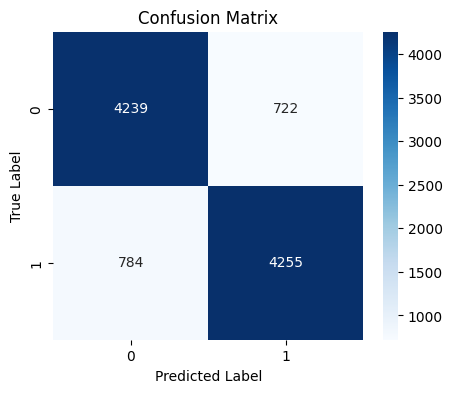

In [14]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

acc = accuracy_score(y_te, predictions)
prec = precision_score(y_te, predictions)
rec = recall_score(y_te, predictions)
f1 = f1_score(y_te, predictions)
roc = roc_auc_score(y_te, predictions)

print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"ROC-AUC Score  : {roc:.4f}")

print("\nDetailed Classification Report:\n")
print(classification_report(y_te, predictions))

conf_mat = confusion_matrix(y_te, predictions)

plt.figure(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


3 Feature Selection Exercise.

3.1 Feature Selection using Wrapper Methods.

Dataset: Breast Cancer Prognostic Dataset

Part 1: Data Loading and Preprocessing

1. Load the Breast Cancer Prognostic Dataset.

2. Dataset is available in Drive.

3. Perform basic exploratory data analysis (EDA) to understand the dataset:

4. Split the dataset into training (80%) and testing (20%) sets.

In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/Concept and Technology of AI/Breast Cancer Wisconsin.csv")

print(df.info())
print(df.describe())
print(df.isnull().sum())

num_features = df.select_dtypes(include=['int64', 'float64']).columns
cat_features = df.select_dtypes(include=['object']).columns

df[num_features] = df[num_features].apply(lambda x: x.fillna(x.median()))

for feature in cat_features:
    df[feature] = df[feature].fillna(df[feature].mode()[0])

for feature in cat_features:
    df[feature] = df[feature].astype('category').cat.codes

print(df.columns.tolist())

X = df.drop(columns=['diagnosis'])
y = df['diagnosis'].astype('category').cat.codes

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Part 2: Apply a Wrapper Method

1. Use Recursive Feature Elimination (RFE) with a Logistic Regression model to perform feature selection:

2. Train the Logistic Regression model using only the selected features.

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import pandas as pd
import matplotlib.pyplot as plt

median_imputer = SimpleImputer(strategy='median')
X_tr_filled = median_imputer.fit_transform(X_tr)
X_te_filled = median_imputer.transform(X_te)

cols = X.columns

if X_tr_filled.shape[1] != len(cols):
    print("Mismatch between features and column names!")
    print("Training data shape:", X_tr_filled.shape)
    print("Number of columns:", len(cols))
else:
    X_tr_df = pd.DataFrame(X_tr_filled, columns=cols)
    X_te_df = pd.DataFrame(X_te_filled, columns=cols)

    lr_model = LogisticRegression(max_iter=1000)

    rfe_selector = RFE(estimator=lr_model, n_features_to_select=5)
    rfe_selector.fit(X_tr_df, y_tr)

    top_features = X_tr_df.columns[rfe_selector.support_]
    print("Top 5 Selected Features:")
    print(top_features)

    feature_ranks = pd.DataFrame({
        'Feature': X_tr_df.columns,
        'Ranking': rfe_selector.ranking_
    }).sort_values(by='Ranking')

    plt.figure(figsize=(8,6))
    plt.barh(feature_ranks['Feature'], feature_ranks['Ranking'])
    plt.xlabel("Feature Rank (1 = Most Important)")
    plt.ylabel("Feature Name")
    plt.title("RFE Feature Ranking using Logistic Regression")
    plt.gca().invert_yaxis()
    plt.show()


Mismatch between features and column names!
Training data shape: (455, 31)
Number of columns: 32


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Part 3: Model Evaluation

1. Evaluate the model’s performance using the testing set:

2. Compare the performance of the model trained on all features versus the model trained on the selected
features.

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/us

Top 5 Selected Features:
Index(['radius_mean', 'texture_se', 'radius_worst', 'compactness_worst',
       'concavity_worst'],
      dtype='object')


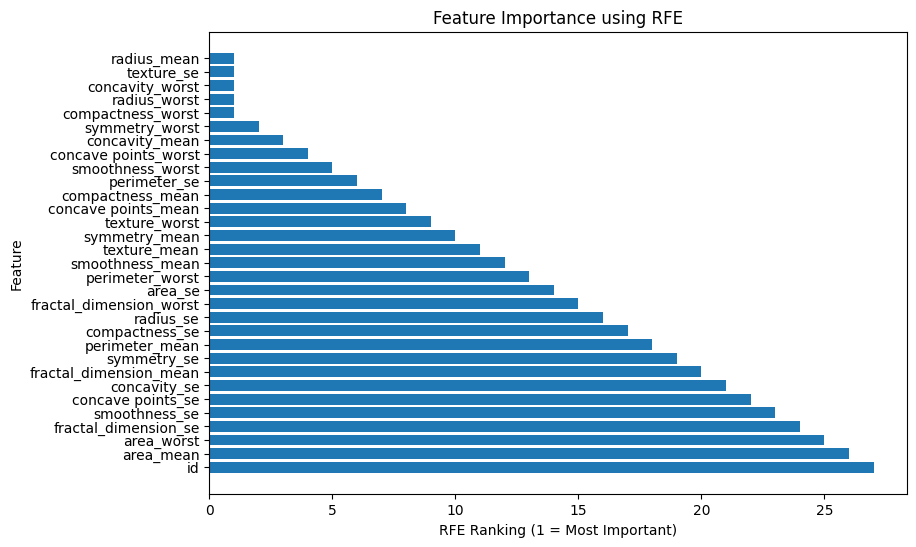

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import pandas as pd
import matplotlib.pyplot as plt

median_fill = SimpleImputer(strategy='median')
X_tr_clean = median_fill.fit_transform(X_tr)
X_te_clean = median_fill.transform(X_te)

col_names = X.columns[:X_tr_clean.shape[1]]

X_tr_df = pd.DataFrame(X_tr_clean, columns=col_names)
X_te_df = pd.DataFrame(X_te_clean, columns=col_names)

lr = LogisticRegression(max_iter=1000)

rfe_selector = RFE(estimator=lr, n_features_to_select=5)
rfe_selector.fit(X_tr_df, y_tr)

important_features = X_tr_df.columns[rfe_selector.support_]
print("Top 5 Selected Features:")
print(important_features)

rank_df = pd.DataFrame({
    'Feature': X_tr_df.columns,
    'RFE_Rank': rfe_selector.ranking_
}).sort_values(by='RFE_Rank')

plt.figure(figsize=(9,6))
plt.barh(rank_df['Feature'], rank_df['RFE_Rank'])
plt.xlabel("RFE Ranking (1 = Most Important)")
plt.ylabel("Feature")
plt.title("Feature Importance using RFE")
plt.gca().invert_yaxis()
plt.show()


Part 4: Experiment

1. Experiment with different numbers of selected features (e.g., top 3, top 7).

2. Discuss how feature selection affects model performance.

In [19]:
for k in [3, 7]:
    rfe_exp = RFE(estimator=lr, n_features_to_select=k)
    rfe_exp.fit(X_tr_df, y_tr)

    chosen_features = X_tr_df.columns[rfe_exp.support_]
    print(f"\nTop {k} Selected Features:")
    print(list(chosen_features))

    lr.fit(X_tr_df[chosen_features], y_tr)
    preds_k = lr.predict(X_te_df[chosen_features])

    print(f"Model Performance using Top {k} Features:")
    print("Accuracy :", accuracy_score(y_te, preds_k))
    print("F1 Score :", f1_score(y_te, preds_k))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Top 3 Selected Features:
['radius_worst', 'compactness_worst', 'concavity_worst']
Model Performance using Top 3 Features:
Accuracy : 0.9298245614035088
F1 Score : 0.8974358974358975


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Top 7 Selected Features:
['radius_mean', 'concavity_mean', 'texture_se', 'radius_worst', 'compactness_worst', 'concavity_worst', 'symmetry_worst']
Model Performance using Top 7 Features:
Accuracy : 0.9736842105263158
F1 Score : 0.9629629629629629
